<a href="https://colab.research.google.com/github/2303A52348/Generative-Ai-2025/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7951.4956 - val_loss: 7282.9878
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8051.6113 - val_loss: 7199.5049
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8151.1416 - val_loss: 7091.1538
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8178.8105 - val_loss: 6943.3184
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7625.5674 - val_loss: 6746.6924
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7775.8892 - val_loss: 6488.7129
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7397.9883 - val_loss: 6145.5303
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6775.4717 - val_loss: 5700.5288
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6512.4155 - val_loss: 5142.8018
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5380.7671 - val_loss: 4472.4941
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4917.5835 - val_loss: 3709.0872
Epoch 12/100
8/8 ━━━

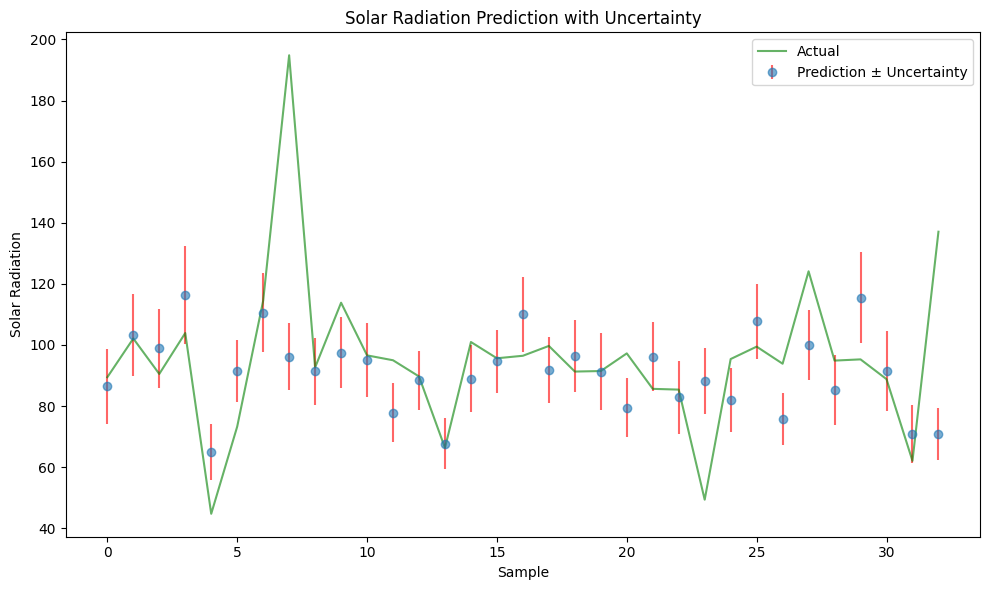


Extreme PM2.5 Threshold: 56.72000000000002


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Load Excel data
df = pd.read_excel("Data_Solar Radiation.xlsx", sheet_name="Sheet1", skiprows=1)
df.columns = [
    "From_Date", "To_Date", "PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "SO2", "CO",
    "O3", "Benzene", "Toluene", "Temp", "RH", "WS", "WD", "BP", "Xylene", "AT", "SR"
]

# Convert types
df["From_Date"] = pd.to_datetime(df["From_Date"], errors="coerce")
df["To_Date"] = pd.to_datetime(df["To_Date"], errors="coerce")
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop missing
df.dropna(inplace=True)

# Split features and target
X = df.drop(columns=["From_Date", "To_Date", "SR"])
y = df["SR"]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build model with Monte Carlo Dropout
def build_model(input_dim, dropout_rate=0.2):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_split=0.1)

# Monte Carlo Dropout - Uncertainty Estimation
T = 100  # forward passes
predictions = np.array([model(X_test, training=True).numpy().flatten() for _ in range(T)])
mean_preds = predictions.mean(axis=0)
std_preds = predictions.std(axis=0)

# Plot uncertainty vs prediction
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), mean_preds, yerr=std_preds, fmt='o', ecolor='red', alpha=0.6, label="Prediction ± Uncertainty")
plt.plot(range(len(y_test)), y_test.values, label="Actual", color='green', alpha=0.6)
plt.title("Solar Radiation Prediction with Uncertainty")
plt.xlabel("Sample")
plt.ylabel("Solar Radiation")
plt.legend()
plt.tight_layout()
plt.show()

# Extreme condition analysis (e.g., top 10% PM2.5)
threshold = df["PM2.5"].quantile(0.9)
extreme_indices = df[df["PM2.5"] >= threshold].index
print(f"\nExtreme PM2.5 Threshold: {threshold}")


In [3]:
# Show uncertainty stats under extreme weather
extreme_preds = predictions[:, [i for i in extreme_indices if i in y_test.index.values and i < predictions.shape[1]]]  # Filter indices to be within test set bounds and predictions bounds

if extreme_preds.size > 0:
    extreme_std = extreme_preds.std(axis=0)
    print(f"Mean prediction uncertainty under extreme PM2.5: {np.mean(extreme_std):.2f}")
else:
    print("No extreme weather samples in test set.")

Mean prediction uncertainty under extreme PM2.5: 11.81
